TODO:
1) EDA
2) Run some training script (ready opensource solution)
3) Analyse results (confusion matrix, some exact cases)

In [1]:
!pip install -U transformers==4.46.3 evaluate==0.4.6 seqeval==1.2.2 datasets==3.1.0 transformers==4.46.3 torch torcheval torchmetrics torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 34.1 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 888.1/888.1 MB 1.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 2.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 72.4 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 18.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 1.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 2.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━

In [2]:
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    TrainingArguments,
    Trainer,
    DataCollatorForTokenClassification,
    BatchEncoding,
    set_seed,
)
import torch
import random
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import wandb
import os

os.environ["WANDB_DISABLED"] = "false"
wandb.init(mode="disabled")

2025-10-13 23:34:03.016284: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1760398443.241588      38 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1760398443.312673      38 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Фиксация всех RNG для воспроизводимости:

In [4]:
def set_all_seeds(seed: int):
    random.seed(seed)  # Python random seed
    np.random.seed(seed)  # NumPy random seed
    torch.manual_seed(seed)  # PyTorch CPU seed
    torch.cuda.manual_seed(seed)  # PyTorch CUDA seed
    torch.cuda.manual_seed_all(seed)  # For multi-GPU setups
    torch.backends.cudnn.deterministic = (
        True  # Ensure deterministic computation in cuDNN
    )
    torch.backends.cudnn.benchmark = (
        False  # Disable cuDNN auto-tuner for reproducibility
    )
    set_seed(seed)  # Hugging Face transformers seed setting


set_all_seeds(1337)

В качестве данных для работы был выбран датасет `Conll2012`

In [5]:
ds = load_dataset("ramybaly/conll2012")

conll2012.py: 0.00B [00:00, ?B/s]

conll2012/train/0000.parquet:   0%|          | 0.00/9.70M [00:00<?, ?B/s]

conll2012/validation/0000.parquet:   0%|          | 0.00/1.40M [00:00<?, ?B/s]

conll2012/test/0000.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/115812 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/15680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/12217 [00:00<?, ? examples/s]

Зарегистрируем дополнительны метаданные о разметке для анализа в будущем (маппинг не поставляется с самим датасето, взят из страницы датасета):

In [6]:
LABEL_NAMES = [
    "O",
    "B-CARDINAL",  # количиственные числительные: three, 200, one million, ...
    "B-DATE",  # даты
    "B-EVENT",  # события: Olympic games, Easter, ...
    "B-FAC",  # сооружения (facilities): Eiffel Tower, JFK airport, ...
    "B-GPE",  # геополитические образования: New York, Texas, ...
    "B-LANGUAGE",  # языки: English, French, ...
    "B-LAW",  # законы и нормативные акты: Constitution, Civil Rights Act, ...
    "B-LOC",  # географические локации: Mount Everest, Nile River, ...
    "B-MONEY",  # денежные выражения: $5, 10 euros, five million rubles
    "B-NORP",  # национальности, религии, политические группы: Russians, Buddhists, Republicans, ...
    "B-ORDINAL",  # порядковые числительные: first, second, third, ...
    "B-ORG",  # организации: Google, United Nations, ...
    "B-PERCENT",  # проценты: 50%, twenty percent
    "B-PERSON",  # имена людей: David Lynch, Maxim Kats, ...
    "B-PRODUCT",  # продукты и бренды: Coca-Cola, Iphone, ...
    "B-QUANTITY",  # измеряемые величины с единицами: 5kg, 10 meters, ...
    "B-TIME",  # время: 2 a.m., morning, ...
    "B-WORK_OF_ART",  # произведения искусства: Mona Lisa, Воронины, ...
    "I-CARDINAL",
    "I-DATE",
    "I-EVENT",
    "I-FAC",
    "I-GPE",
    "I-LANGUAGE",
    "I-LAW",
    "I-LOC",
    "I-MONEY",
    "I-NORP",
    "I-ORDINAL",
    "I-ORG",
    "I-PERCENT",
    "I-PERSON",
    "I-PRODUCT",
    "I-QUANTITY",
    "I-TIME",
    "I-WORK_OF_ART",
]

ENTITY_MAPPING = {i: ent for i, ent in enumerate(LABEL_NAMES)}

In [7]:
ds

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 115812
    })
    validation: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 15680
    })
    test: Dataset({
        features: ['id', 'tokens', 'pos_tags', 'tags'],
        num_rows: 12217
    })
})

In [8]:
ds_train = ds["train"].remove_columns(["id", "pos_tags"])
ds_val = ds["validation"].remove_columns(["id", "pos_tags"])
ds_test = ds["test"].remove_columns(["id", "pos_tags"])

df_train = ds_train.to_pandas()
df_val = ds_val.to_pandas()
df_test = ds_test.to_pandas()

Датасет 

In [9]:
df_train

,tokens,tags
0,"[Big, Managers, on, Campus]","[0, 0, 0, 0]"
1,"[In, recent, years, ,, advanced, education, fo...","[0, 2, 20, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,"[With, this, trend, ,, suddenly, the, mature, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,"[In, order, to, attract, this, group, of, seas...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 27, 27..."
4,"[In, response, ,, each, year, over, 1000, matu...","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...,...
115807,"[In, fact, ,, Iraq, has, almost, sunk, into, a...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115808,"[The, same, day, ,, the, US, National, Broadca...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115809,"[Analysts, here, have, pointed, out, that, Ann...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
115810,"[Calls, from, within, the, US, for, the, withd...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [10]:
classes_cnt = {}
for tag_arr in tqdm(df_train["tags"]):
    for cls_num in tag_arr:
        cls_name = ENTITY_MAPPING[cls_num]
        if cls_name != "O":
            cls_name = cls_name[2:]
        if cls_name not in classes_cnt:
            classes_cnt[cls_name] = 1
        else:
            classes_cnt[cls_name] += 1

100%|██████████| 115812/115812 [00:00<00:00, 122499.79it/s]


Text(0.5, 1.0, 'Token classes distribution in train dataset')

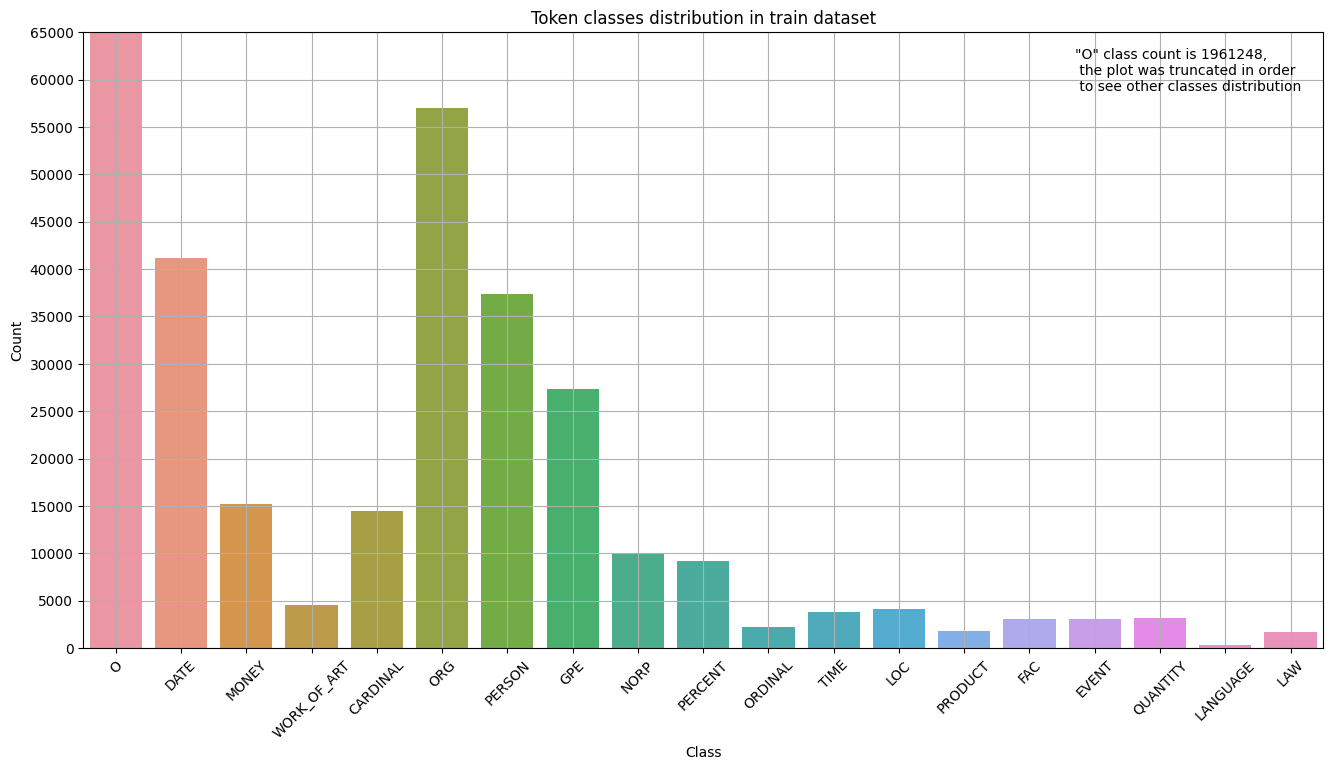

In [11]:
df = pd.DataFrame(list(classes_cnt.items()), columns=["Class", "Count"])

# Create the bar plot using Seaborn
plt.figure(figsize=(16, 8))  # Optional: Adjust figure size
sns.barplot(x="Class", y="Count", data=df)
plt.yticks(np.arange(0, max(df["Count"]) + 1, 5000))
plt.ylim((0, 0.065 * 1e6))
plt.xticks(rotation=45)
plt.text(
    0.80,
    0.90,
    f'"O" class count is {classes_cnt["O"]},\n the plot was truncated in order\n to see other classes distribution',
    horizontalalignment="left",
    verticalalignment="bottom",
    transform=plt.gca().transAxes,
    fontsize=10,
    color="black",
)
plt.grid(True)

# Add a title to the plot
plt.title("Token classes distribution in train dataset")

In [12]:
idx = 116
dict(
    zip(
        df_train.iloc[idx]["tokens"],
        [ENTITY_MAPPING[klass] for klass in df_train.iloc[idx]["tags"]],
    )
)

{'Last': 'B-DATE',
 'year': 'I-DATE',
 ',': 'O',
 'one': 'B-CARDINAL',
 'professor': 'O',
 'made': 'O',
 'a': 'O',
 'big': 'O',
 'hit': 'O',
 'with': 'O',
 'over': 'O',
 '30': 'B-CARDINAL',
 'students': 'O',
 'taking': 'O',
 'them': 'O',
 'to': 'O',
 'mainland': 'O',
 'China': 'B-GPE',
 'for': 'O',
 'ten': 'B-DATE',
 'days': 'I-DATE',
 'familiarize': 'O',
 'the': 'O',
 'investment': 'O',
 'environment': 'O',
 'there': 'O',
 '.': 'O'}

In [13]:
seq_lens = []
for tok_arr in tqdm(df_train["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print('Train set:')
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_val["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print('Validation set:')
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}\n"
)

seq_lens = []
for tok_arr in tqdm(df_test["tokens"]):
    seq_lens.append(len(tok_arr))
avg_train_seqlen = sum(seq_lens) / len(seq_lens)
print('Test set:')
print(
    f"Min sentance length: {min(seq_lens):.2f}\nAvg sentance length: {avg_train_seqlen:.2f}\nMax sentance length: {max(seq_lens):.2f}"
)

100%|██████████| 115812/115812 [00:00<00:00, 2692691.27it/s]


Train set:
Min sentance length: 1.00
Avg sentance length: 19.00
Max sentance length: 228.00



100%|██████████| 15680/15680 [00:00<00:00, 2719317.21it/s]


Validation set:
Min sentance length: 1.00
Avg sentance length: 19.43
Max sentance length: 275.00



100%|██████████| 12217/12217 [00:00<00:00, 2644465.71it/s]

Test set:
Min sentance length: 1.00
Avg sentance length: 18.84
Max sentance length: 151.00


In [ ]:
# TODO distro plot for lengths

### Модель


Для задачи подходит декодерная модель BERT с двунаправленным attention-механизмом.
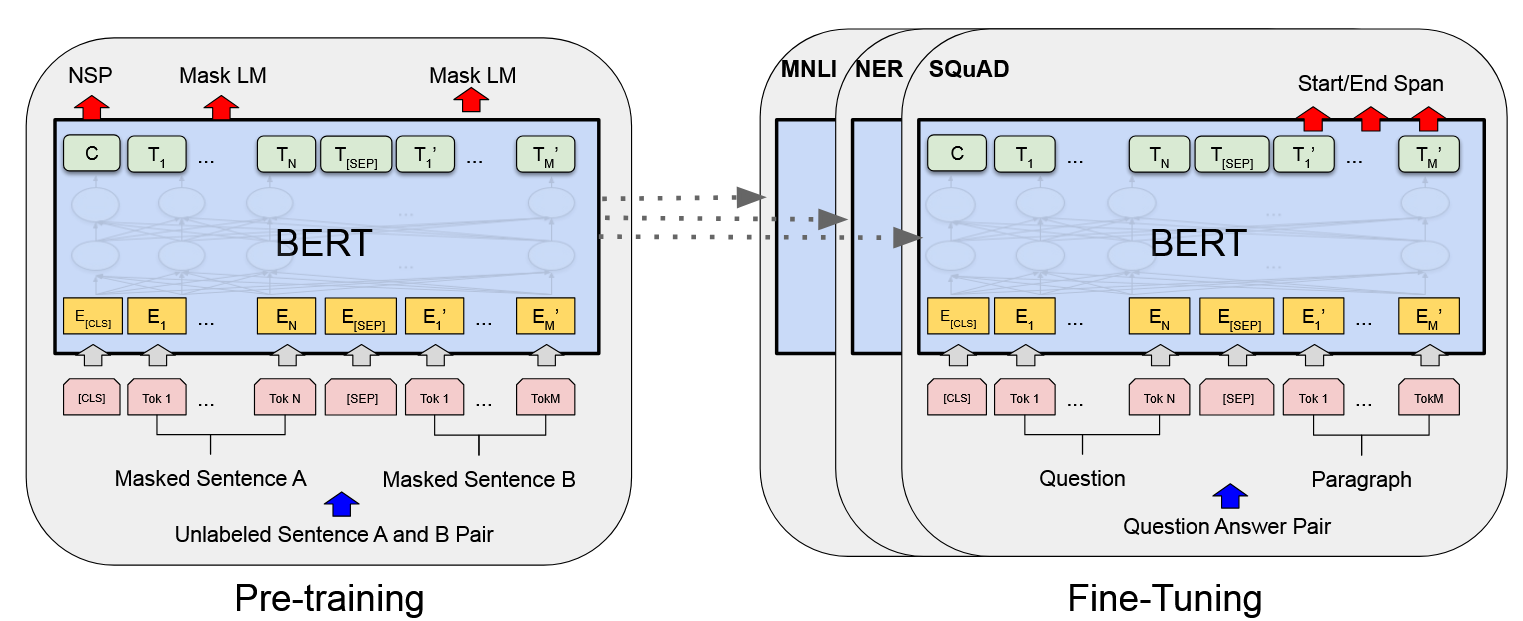
В пайплайне применяется предобученная модель BERT, self-supervised задача на претренировке состоит из 2 частей - $MLM^1$ и $NSP^2$:


1. 15% процентов токенов маскируются, то есть заменяются на [MASK] 
2. Бинарный обджектив-индиктор, являются для заколлейченых в 1 сэмпл преложения реально последовательно встречающимися в тексте.

NER-задача сводится к классификации каждого токена, что означает, что больше подходит дискриминативная модель, ей и является BERT; специфика NER задачи также требует cased-токенизации, так как потенциально поможет в некоторых случаях определить собственные имена.

EDA датасета показывает оценку длины в словах, BPE, как subword метод, увеличивает длину после токенизации; распространенной оценкой является $|text|_{words}\approx 0.75 \times |text|_{BPE-tokens}$ 

Так как максимальное количество слов в датасете 228, для того, чтобы все токены точно были обработаны требуется $\lceil228/0.75\rceil = 304$, длины принято брать степенями двойки, соответственно нужна модель с $2^{\lceil\log_2 304\rceil} = 2^9 = 512$ токенов.

In [14]:
MODEL_NAME = "bert-base-cased"
MAX_LENGTH = 512
BATCH_SIZE = 32
NUM_EPOCHS = 5
LEARNING_RATE = 2e-5

In [15]:
ds_full = dataset = DatasetDict(
    {"train": ds_train, "validation": ds_val, "test": ds_test}
)

In [16]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [17]:
label2id = {label: i for i, label in enumerate(LABEL_NAMES)}
id2label = {i: label for i, label in enumerate(LABEL_NAMES)}

Разметка датасета имеет тип BIO, стандартный для NER. Однако, в изначальном варианте размечено каждое слово, которое для модели может состоять из нескольких токенов в силу subword-токенизации, соответственно, нужно трансформировать разметку - распротранить лейблы сущностей на все токены:
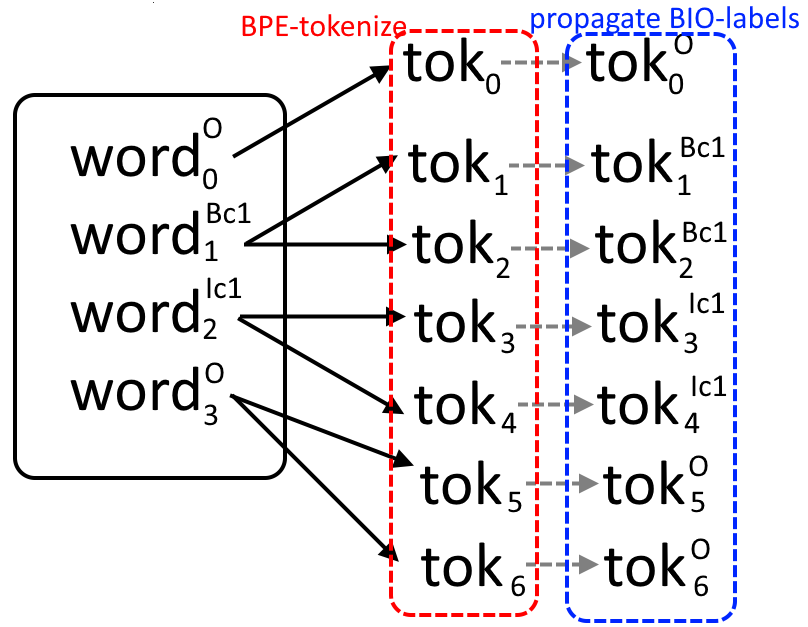

In [18]:
def tokenize_and_align_labels(data, tok_kwargs, ignore_idx=-100):
    """
    Токенизация текста и выравнивание меток с учетом разделения на подтокены
    """
    tokenized_inputs = tokenizer(
        data["tokens"],
        **tok_kwargs,  # Будем возвращать списки, а не тензоры
    )

    labels = []
    all_word_ids = []
    for i, label in enumerate(data["tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            # Специальные токены получают метку ignore_idx
            if word_idx is None:
                label_ids.append(ignore_idx)
            # Для первого токена каждого слова используем соответствующую метку
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            # Для подтокенов используем метку ignore_idx или метку текущего слова (в зависимости от задачи)
            else:
                label_ids.append(ignore_idx)
            previous_word_idx = word_idx

        labels.append(label_ids)
        all_word_ids.append(word_ids)

    tokenized_inputs["labels"] = labels
    tokenized_inputs["word_ids"] = all_word_ids

    return tokenized_inputs

После предсказаний subword-модели потребуется восстановить разметку до woed-уровня:
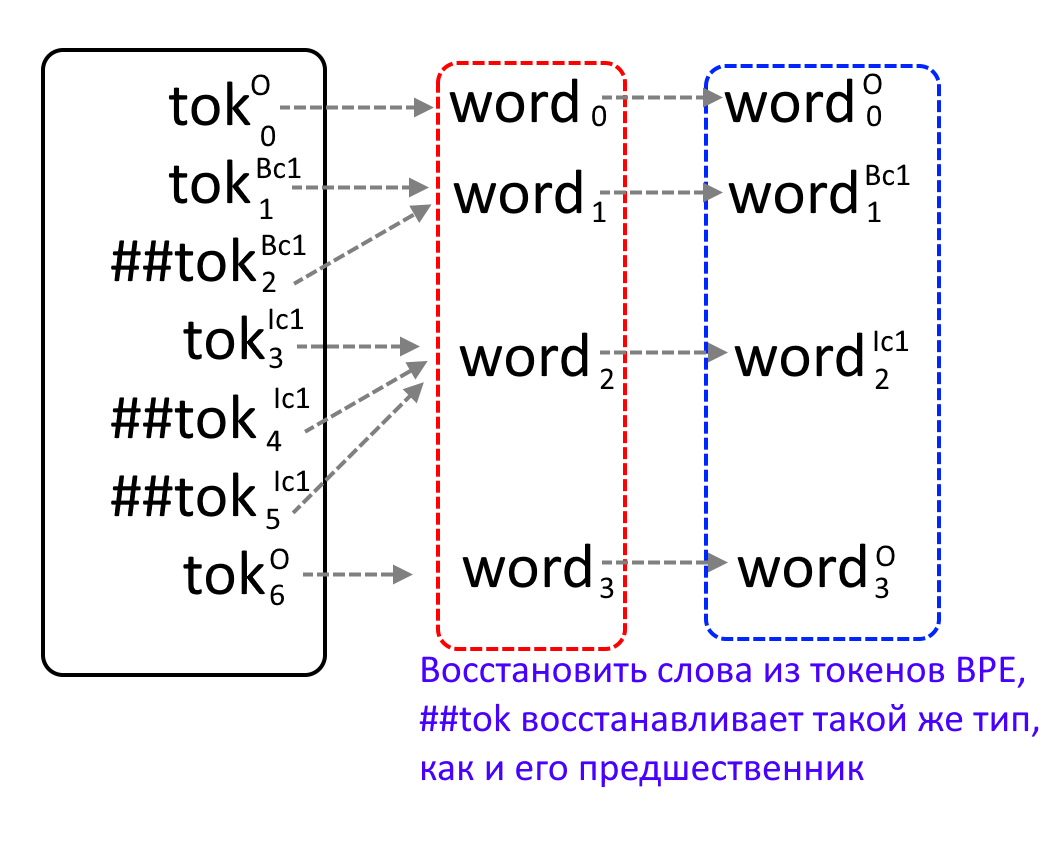

In [19]:
tok_kwargs_analytical = {
    "truncation": False,
    "padding": False,
    "is_split_into_words": True,
    "return_tensors": None,
}

In [20]:
tokenized_datasets_analytical = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs_analytical, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/115812 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [21]:
for stage in tokenized_datasets_analytical.keys():
    print(
        f"Max BPE-token length of sample in {stage} split:",
        max(
            tokenized_datasets_analytical[stage]
            .to_pandas()["input_ids"]
            .apply(lambda x: len(x))
        ),
    )

Max BPE-token length of sample in train split: 270
Max BPE-token length of sample in validation split: 353
Max BPE-token length of sample in test split: 171


Фактическая проверка показывает, что есть последовательности $256\lt|text|_{BPE-tokens}$, при этом $\forall text\in Data: |text|_{BPE-tokens}\lt512$, длину нужно поддерживать на уровне 512 BPE-токенов. 

In [22]:
del tokenized_datasets_analytical

Для консистениности, убедившись в правилности оценки, будем поддерживать следующие параметры токенизации:

In [23]:
tok_kwargs = {
    "truncation": True,
    "padding": True,
    "is_split_into_words": True,
    "max_length": MAX_LENGTH,
    "return_tensors": None,
}

In [24]:
tokenized_datasets = dataset.map(
    lambda x: tokenize_and_align_labels(x, tok_kwargs, -100),
    batched=True,
    remove_columns=dataset["train"].column_names,
)

Map:   0%|          | 0/115812 [00:00<?, ? examples/s]

Map:   0%|          | 0/15680 [00:00<?, ? examples/s]

Map:   0%|          | 0/12217 [00:00<?, ? examples/s]

In [25]:
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME, num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id
)

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [28]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True)

In [30]:
metric = evaluate.load("seqeval")

In [31]:
def compute_metrics(p, ignore_index=-100):
    """
    Вычисление метрик (precision, recall, f1) для NER
    """
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    # Убираем специальные токены (метка -100)
    true_predictions = [
        [LABEL_NAMES[p] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [LABEL_NAMES[l] for (p, l) in zip(prediction, label) if l != ignore_index]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [32]:
training_args = TrainingArguments(
    output_dir="./ner-model",
    evaluation_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    save_strategy="epoch",
    logging_dir="./logs",
    push_to_hub=False,
    report_to=None,
    load_best_model_at_end=True,
    metric_for_best_model="eval_f1",
    greater_is_better=True,
    save_total_limit=1,
)

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=lambda x: compute_metrics(x, -100),
)

/tmp/ipykernel_38/3442625466.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [36]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.078300,0.075456,0.827111,0.881645,0.853508,0.975914
2,0.053500,0.072729,0.833310,0.894026,0.862601,0.977411
3,0.037200,0.072982,0.850534,0.887934,0.868832,0.978894
4,0.028900,0.079961,0.851291,0.889309,0.869885,0.978714
5,0.023600,0.081052,0.856362,0.885182,0.870534,0.979022


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked t

TrainOutput(global_step=9050, training_loss=0.05365257946825818, metrics={'train_runtime': 13850.3431, 'train_samples_per_second': 41.808, 'train_steps_per_second': 0.653, 'total_flos': 7.449716308349784e+16, 'train_loss': 0.05365257946825818, 'epoch': 5.0})

In [37]:
trainer.save_model("./ner-final-model-5-epochs")

## Валидация

In [38]:
# predictions = trainer.predict(tokenized_datasets["test"])
model_path = "./ner-final-model-5-epochs"
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path,  num_labels=len(LABEL_NAMES), id2label=id2label, label2id=label2id)

label_names = ds_test.features["tags"].feature.names

In [39]:
trainer = Trainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_label_ids = np.argmax(predictions, axis=-1)

/tmp/ipykernel_38/1267966716.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


In [40]:
tokenized_datasets["test"]

Dataset({
    features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels', 'word_ids'],
    num_rows: 12217
})

In [41]:
from collections import Counter

def align_predictions(tokenizer, raw_dataset, tokenized_dataset, predictions, max_length=512):
    id2label = model.config.id2label
    pred_label_ids = np.argmax(predictions, axis=-1)

    results = []

    for i in range(len(raw_dataset)):
        # Повторно токенизируем исходные токены, чтобы получить word_ids
        tokenized = tokenizer(
            raw_dataset[i]["tokens"],
            truncation=True,
            is_split_into_words=True,
            max_length=max_length,
            return_tensors=None,
        )

        word_ids = tokenized.word_ids()
        words = raw_dataset[i]["tokens"]
        true_labels = raw_dataset[i]["tags"]

        # предсказания из готового токенизированного датасета (в том же порядке)
        pred_ids = pred_label_ids[i]
        word_to_preds = {}

        for token_idx, widx in enumerate(word_ids):
            if widx is None:
                continue
            word_to_preds.setdefault(widx, []).append(pred_ids[token_idx])

        aligned = []
        for widx, word in enumerate(words):
            preds_for_word = word_to_preds.get(widx, [])
            if preds_for_word:
                pred_id = Counter(preds_for_word).most_common(1)[0][0]
                pred_label = id2label[pred_id]
                if len(aligned) and aligned[-1][1] == "O" and pred_label.startswith('I'):
                    pred_label = f"B{pred_label[1:]}"
            else:
                pred_label = "O"

            true_id = true_labels[widx]
            true_label = id2label[true_id] if true_id in id2label else str(true_id)

            aligned.append((word, pred_label, true_label))

        results.append(aligned)

    return results

In [42]:
aligned = align_predictions(tokenizer, dataset["test"], tokenized_datasets["test"], predictions, max_length=MAX_LENGTH)

In [43]:
aligned[0]

[('Powerful', 'O', 'B-WORK_OF_ART'),
 ('Tools', 'O', 'I-WORK_OF_ART'),
 ('for', 'O', 'I-WORK_OF_ART'),
 ('Biotechnology', 'O', 'I-WORK_OF_ART'),
 ('-', 'O', 'I-WORK_OF_ART'),
 ('Biochips', 'O', 'I-WORK_OF_ART')]

In [44]:
all_preds = [list(map(lambda tuple_: tuple_[1], list_)) for list_ in aligned]
all_gt = [list(map(lambda tuple_: tuple_[2], list_)) for list_ in aligned]

In [ ]:
# all_preds = [tuple_[1] for sentence in aligned for tuple_ in sentence ]
# all_gt = [tuple_[2] for sentence in aligned for tuple_ in sentence ]

In [45]:
results = metric.compute(
    predictions=all_preds, references=all_gt
)


print("Overall Metrics:")
print(f"Precision: {results['overall_precision']:.4f}")
print(f"Recall: {results['overall_recall']:.4f}")
print(f"F1-Score: {results['overall_f1']:.4f}")
print(f"Accuracy: {results['overall_accuracy']:.4f}")

print("\nDetailed Metrics per class:")
for key in results:
    if key not in [
        "overall_precision",
        "overall_recall",
        "overall_f1",
        "overall_accuracy",
    ]:
        print(f"\n{key}:")
        print(f"  Precision: {results[key]['precision']:.4f}")
        print(f"  Recall: {results[key]['recall']:.4f}")
        print(f"  F1-Score: {results[key]['f1']:.4f}")

Overall Metrics:
Precision: 0.8383
Recall: 0.8639
F1-Score: 0.8509
Accuracy: 0.9780

Detailed Metrics per class:

CARDINAL:
  Precision: 0.7994
  Recall: 0.8209
  F1-Score: 0.8100

DATE:
  Precision: 0.8023
  Recall: 0.8539
  F1-Score: 0.8273

EVENT:
  Precision: 0.5514
  Recall: 0.6941
  F1-Score: 0.6146

FAC:
  Precision: 0.6014
  Recall: 0.5973
  F1-Score: 0.5993

GPE:
  Precision: 0.9175
  Recall: 0.9002
  F1-Score: 0.9088

LANGUAGE:
  Precision: 0.8571
  Recall: 0.5455
  F1-Score: 0.6667

LAW:
  Precision: 0.5000
  Recall: 0.5909
  F1-Score: 0.5417

LOC:
  Precision: 0.6695
  Recall: 0.7349
  F1-Score: 0.7007

MONEY:
  Precision: 0.8591
  Recall: 0.8930
  F1-Score: 0.8757

NORP:
  Precision: 0.8782
  Recall: 0.9101
  F1-Score: 0.8938

ORDINAL:
  Precision: 0.7042
  Recall: 0.8164
  F1-Score: 0.7562

ORG:
  Precision: 0.8541
  Recall: 0.8916
  F1-Score: 0.8724

PERCENT:
  Precision: 0.8505
  Recall: 0.8922
  F1-Score: 0.8708

PERSON:
  Precision: 0.9030
  Recall: 0.9030
  F1-Score:

In [46]:
aligned[500]

[('Wu', 'B-PERSON', 'B-PERSON'),
 ('Wu', 'I-PERSON', 'I-PERSON'),
 ('-', 'I-PERSON', 'I-PERSON'),
 ('ta', 'I-PERSON', 'I-PERSON'),
 (',', 'O', 'O'),
 ('a', 'O', 'O'),
 ('plumber', 'O', 'O'),
 ('who', 'O', 'O'),
 ('runs', 'O', 'O'),
 ('the', 'B-ORG', 'B-ORG'),
 ('Democracy', 'I-ORG', 'I-ORG'),
 ('Association', 'I-ORG', 'I-ORG'),
 (',', 'O', 'O'),
 ('says', 'O', 'O'),
 (':', 'O', 'O'),
 ('"', 'O', 'O'),
 ('People', 'O', 'O'),
 ('were', 'O', 'O'),
 ('already', 'O', 'O'),
 ('doing', 'O', 'O'),
 ('their', 'O', 'O'),
 ('bit', 'O', 'O'),
 ('for', 'O', 'O'),
 ('the', 'O', 'O'),
 ('community', 'O', 'O'),
 ('over', 'B-DATE', 'O'),
 ('ten', 'B-DATE', 'B-DATE'),
 ('years', 'I-DATE', 'I-DATE'),
 ('ago', 'I-DATE', 'I-DATE'),
 (',', 'O', 'O'),
 ('but', 'O', 'O'),
 ('not', 'O', 'O'),
 ('openly', 'O', 'O'),
 ('.', 'O', 'O')]

In [ ]:
# from collections import defaultdict


# def print_examples_by_class(
#     all_word_predictions,
#     all_word_true_labels,
#     original_dataset,
#     label_names,
#     num_examples=2,
# ):
#     """
#     Выводит примеры предложений для каждого класса, где в GT есть этот класс
#     """

#     # Собираем примеры для каждого класса
#     class_examples = defaultdict(list)

#     for i in range(len(all_word_predictions)):
#         true_labels = all_word_true_labels[i]
#         pred_labels = all_word_predictions[i]
#         tokens = original_dataset[i]["tokens"]

#         # Находим уникальные классы в этом предложении (исключая 'O')
#         present_classes = set()
#         for label in true_labels:
#             if label != "O":
#                 present_classes.add(label)

#         # Для каждого присутствующего класса сохраняем пример
#         for cls in present_classes:
#             if len(class_examples[cls]) < num_examples:
#                 class_examples[cls].append(
#                     {"tokens": tokens, "true": true_labels, "pred": pred_labels, "i": i}
#                 )

#     # Выводим примеры для каждого класса
#     for cls in sorted(class_examples.keys()):
#         print(f"\n{'='*80}")
#         print(f"КЛАСС: {cls}")
#         print(f"{'='*80}")

#         for example_idx, example in enumerate(class_examples[cls]):
#             print(f"\nПример {example_idx + 1}:")
#             print("-" * 40)

#             # Выводим предложение с цветовой разметкой
#             for token, true_label, pred_label in zip(
#                 example["tokens"], example["true"], example["pred"]
#             ):
#                 true_color = "✓" if true_label == cls else " "
#                 pred_color = "✓" if pred_label == cls else " "
#                 match_indicator = " ✅" if true_label == pred_label else " ❌"

#                 print(
#                     f"{true_color} {pred_color} {token:15} | GT: {true_label:15} | PRED: {pred_label:15}{match_indicator}"
#                 )

In [ ]:
# print_examples_by_class(all_preds, all_gt, ds_val, LABEL_NAMES)